### for download datasets:

In [4]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")
print("Path to dataset files:", path)

Resuming download from 2118123520 bytes (1208697304 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/breast-histopathology-images?dataset_version_number=1 (2118123520/3326820824) bytes left.


100%|██████████| 3.10G/3.10G [08:17<00:00, 2.43MB/s]

Extracting model files...


Path to dataset files: /Users/mohammad/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


### main code:

In [ ]:
import os
import numpy as np
import shutil
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from skimage.filters import gaussian
from skimage.util import random_noise
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [3]:
cancer_rays_dir     = os.listdir("./versions/1/IDC_regular_ps50_idx5") 
all_rays_dir        = "all_rays_dir"  
cancer_rays_dir_str ="./versions/1//IDC_regular_ps50_idx5/"

In [4]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['9036', '10268', '10257', '8913', '13613', '8914', '15510', '10259', '16165', '10292', '12951', '10261', '10295', '9259', '12750', '13020', '16552', '12905', '9266', '16555', '13018', '9261', '9257', '12934', '12933', '9250', '10260', '10258', '10293', '9037', '10269', '16531', '10256', '15516', '12932', '12935', '9256', '16554', '9260', '13019', '16553', '13021', '8984', '9258', '12751', '9267', '12876', '12882', '15634', '12871', '14188', '15633', '9324', '12878', '9323', '9383', '8867', '9346', '9174', '12822', '9173', '9322', '9325', '12879', '14189', '12870', '12884', '12241', '15632', '12883', '12877', '9126', '13106', '12823', '13591', '9175', '12824', '9347', '9181', '9382', '10307', '13916', '10300', '14306', '15471', '16896', '14156', '9135', '12890', '12897', '10308', '10301', '10306', '12896', '14157', '12891', '12898', '14192', '13458', '9083', '9077', '13460', '8955', '12910', '9041', '14210', '14082', '10274', '9227', '10273', '13402', '14078', '9023', '12911', '14211',

In [5]:
os.makedirs(all_rays_dir, exist_ok=True)

In [6]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [7]:
for patient in os.listdir(cancer_rays_dir_str):
    if patient.startswith('.'):  
        continue

    path_0 = os.path.join(cancer_rays_dir_str, str(patient), '0')
    path_1 = os.path.join(cancer_rays_dir_str, str(patient), '1')

    if not os.path.isdir(path_0) or not os.path.isdir(path_1):
        continue  

    file_list_0 = os.listdir(path_0)
    file_list_1 = os.listdir(path_1)

    for fname in file_list_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [8]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

277524

In [9]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

image_id
0   10286_idx5_x1251_y351_class1.png
1  14079_idx5_x2151_y1401_class0.png
2   12749_idx5_x1451_y701_class0.png
3   14157_idx5_x1651_y301_class0.png
4   10269_idx5_x1351_y651_class1.png

In [10]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0   10286_idx5_x1251_y351_class1.png      1
1  14079_idx5_x2151_y1401_class0.png      0
2   12749_idx5_x1451_y701_class0.png      0
3   14157_idx5_x1651_y301_class0.png      0
4   10269_idx5_x1351_y651_class1.png      1
5    9266_idx5_x1901_y701_class0.png      0
6  13693_idx5_x1901_y2851_class0.png      0
7  13022_idx5_x1501_y1001_class0.png      0
8  10307_idx5_x1351_y1801_class1.png      1
9  15510_idx5_x1801_y1001_class0.png      0

In [11]:
def extract_patient_id(x):
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0   10286_idx5_x1251_y351_class1.png      1      10286
1  14079_idx5_x2151_y1401_class0.png      0      14079
2   12749_idx5_x1451_y701_class0.png      0      12749
3   14157_idx5_x1651_y301_class0.png      0      14157
4   10269_idx5_x1351_y651_class1.png      1      10269

In [12]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

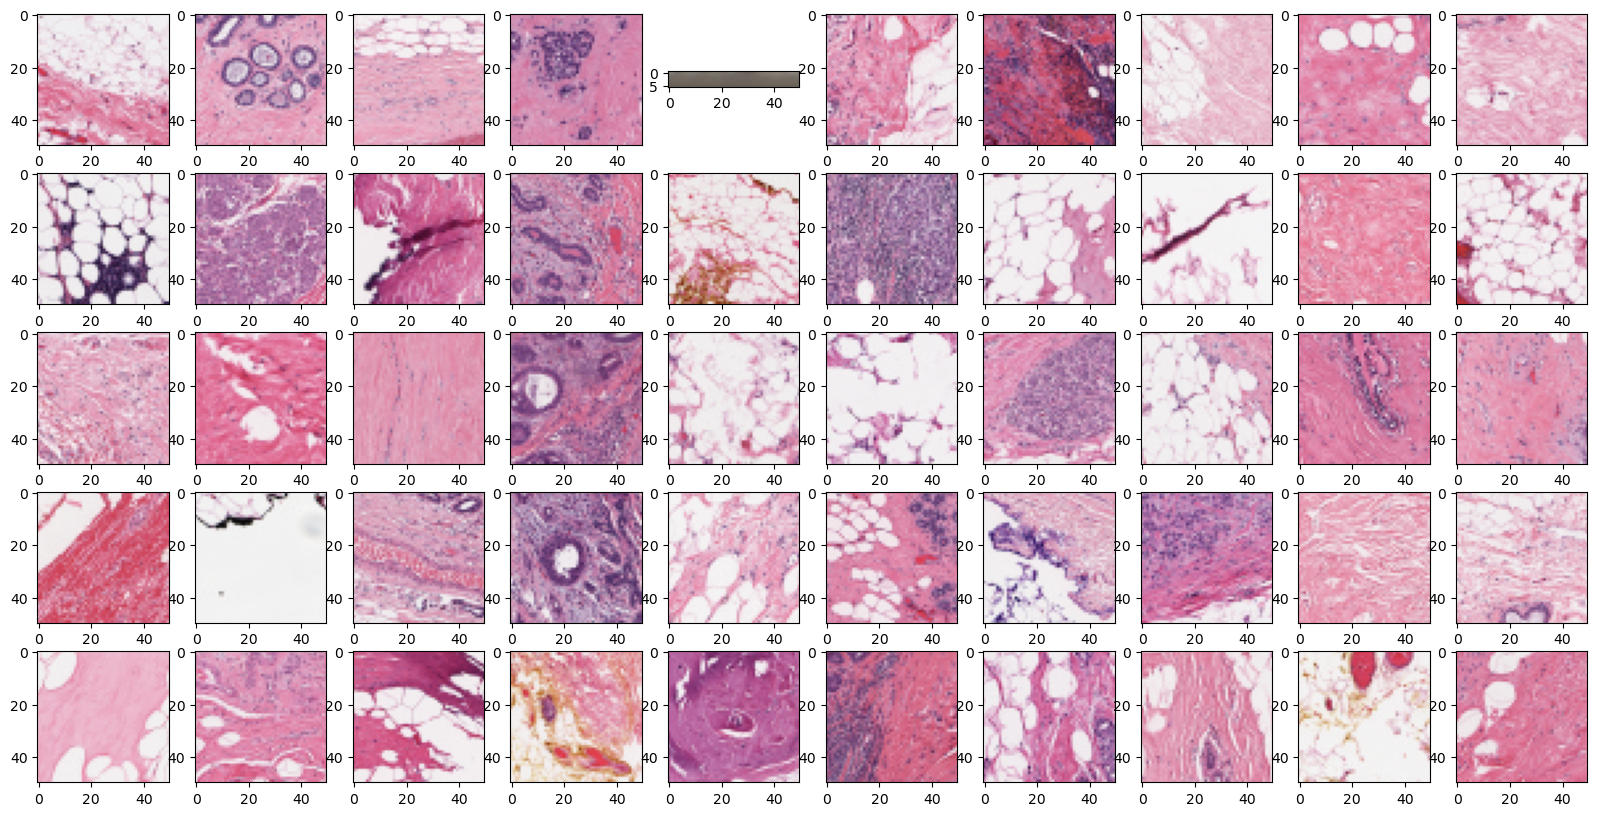

In [13]:
data.target = data.target.astype(np.int64)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

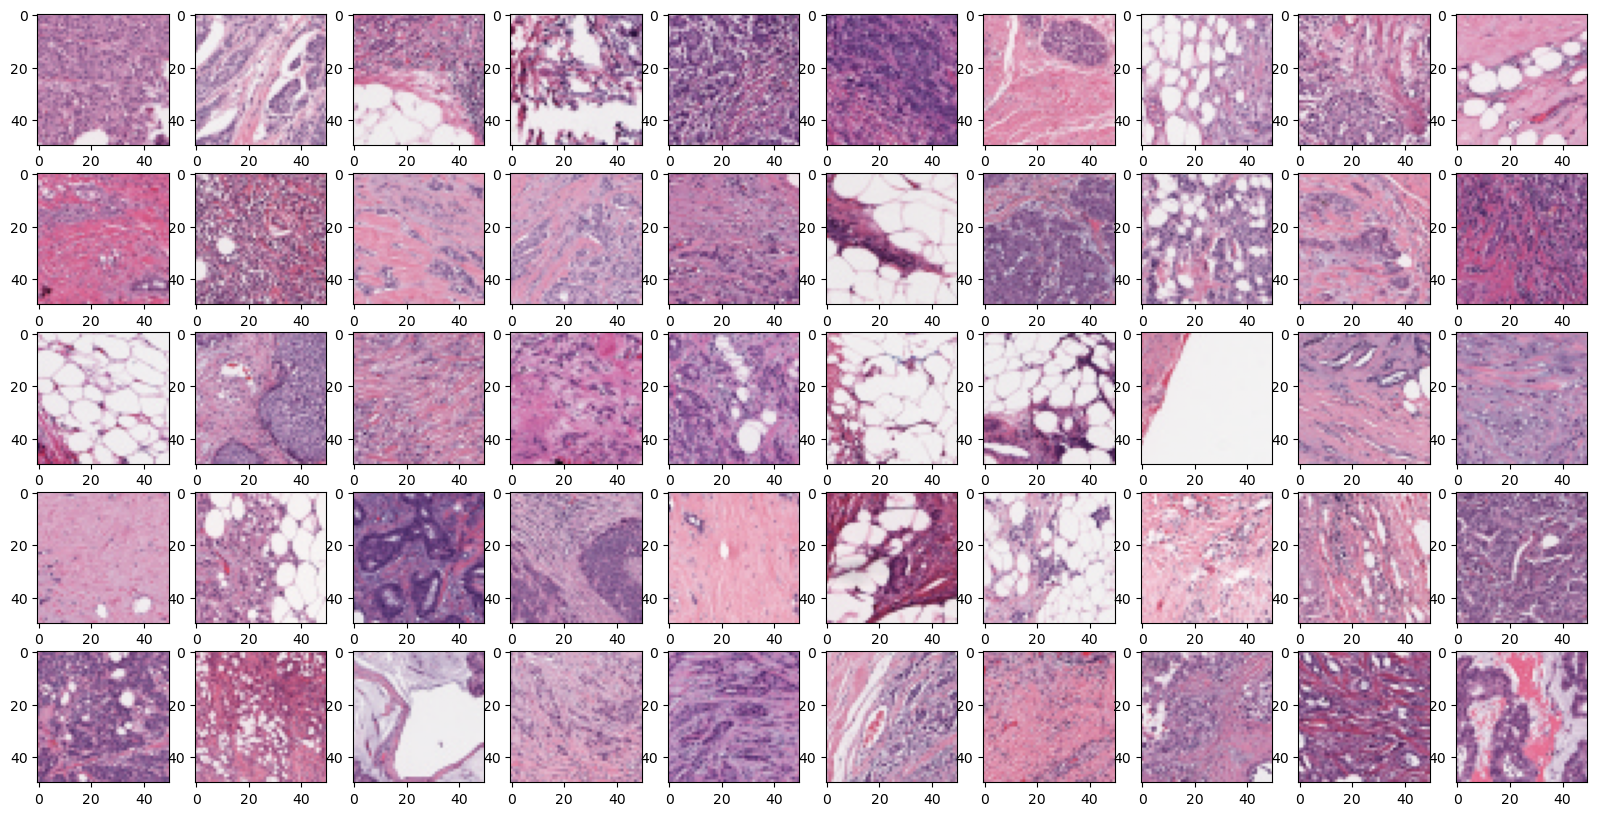

In [14]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Text(0.5, 0, 'no(0) versus yes(1)')

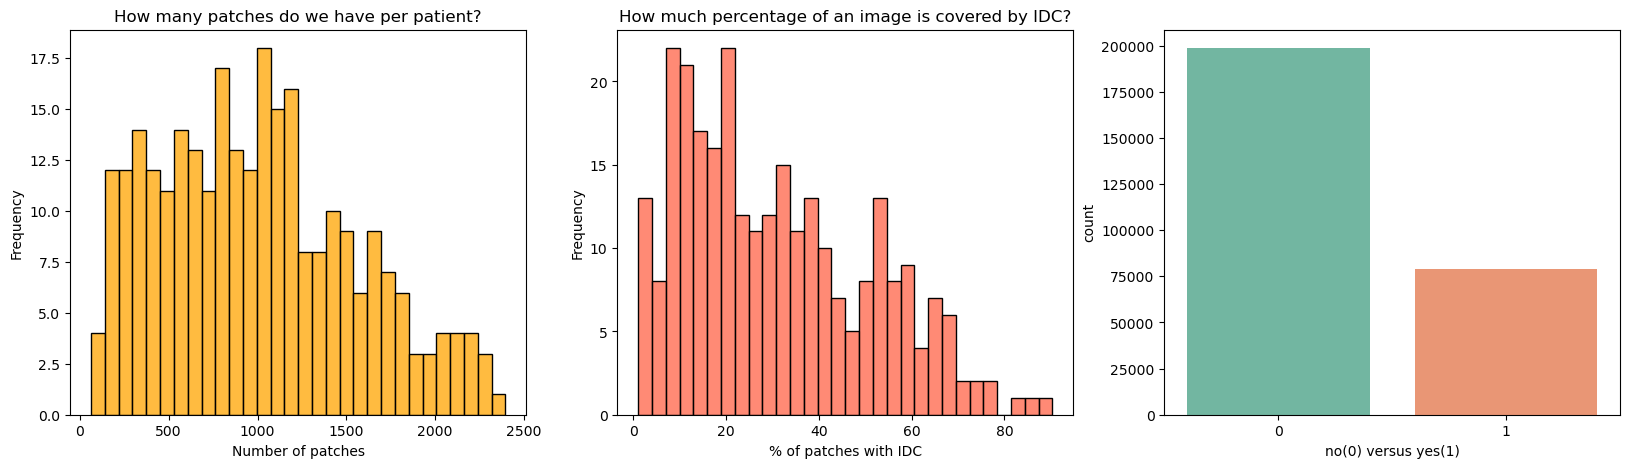

In [15]:
cancer_perc = data.groupby("patient_id")["target"].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

sns.histplot(cancer_perc.loc[:, 1].fillna(0) * 100, ax=ax[1], color="Tomato", bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

sns.countplot(x=data["target"], hue=data["target"], palette="Set2", ax=ax[2], legend=False)
ax[2].set_xlabel("no(0) versus yes(1)")


In [16]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:, "x"].str.replace("x", "", case=False).astype(np.int64)
    coord.loc[:, "y"] = coord.loc[:, "y"].str.replace("y", "", case=False).astype(np.int64)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)

    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:, "x"].str.replace("x", "", case=False).astype(np.int64)
    dataframe.loc[:, "y"] = dataframe.loc[:, "y"].str.replace("y", "", case=False).astype(np.int64)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")

    patient_df = pd.concat([df_0, df_1], ignore_index=True)

    return patient_df


In [17]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x    y  target                                               path
0  2001  351       0  ./versions/1//IDC_regular_ps50_idx5/10286/0/10...
1  1201  951       0  ./versions/1//IDC_regular_ps50_idx5/10286/0/10...
2  1051  901       0  ./versions/1//IDC_regular_ps50_idx5/10286/0/10...
3  2001  451       0  ./versions/1//IDC_regular_ps50_idx5/10286/0/10...
4  1751  501       0  ./versions/1//IDC_regular_ps50_idx5/10286/0/10...

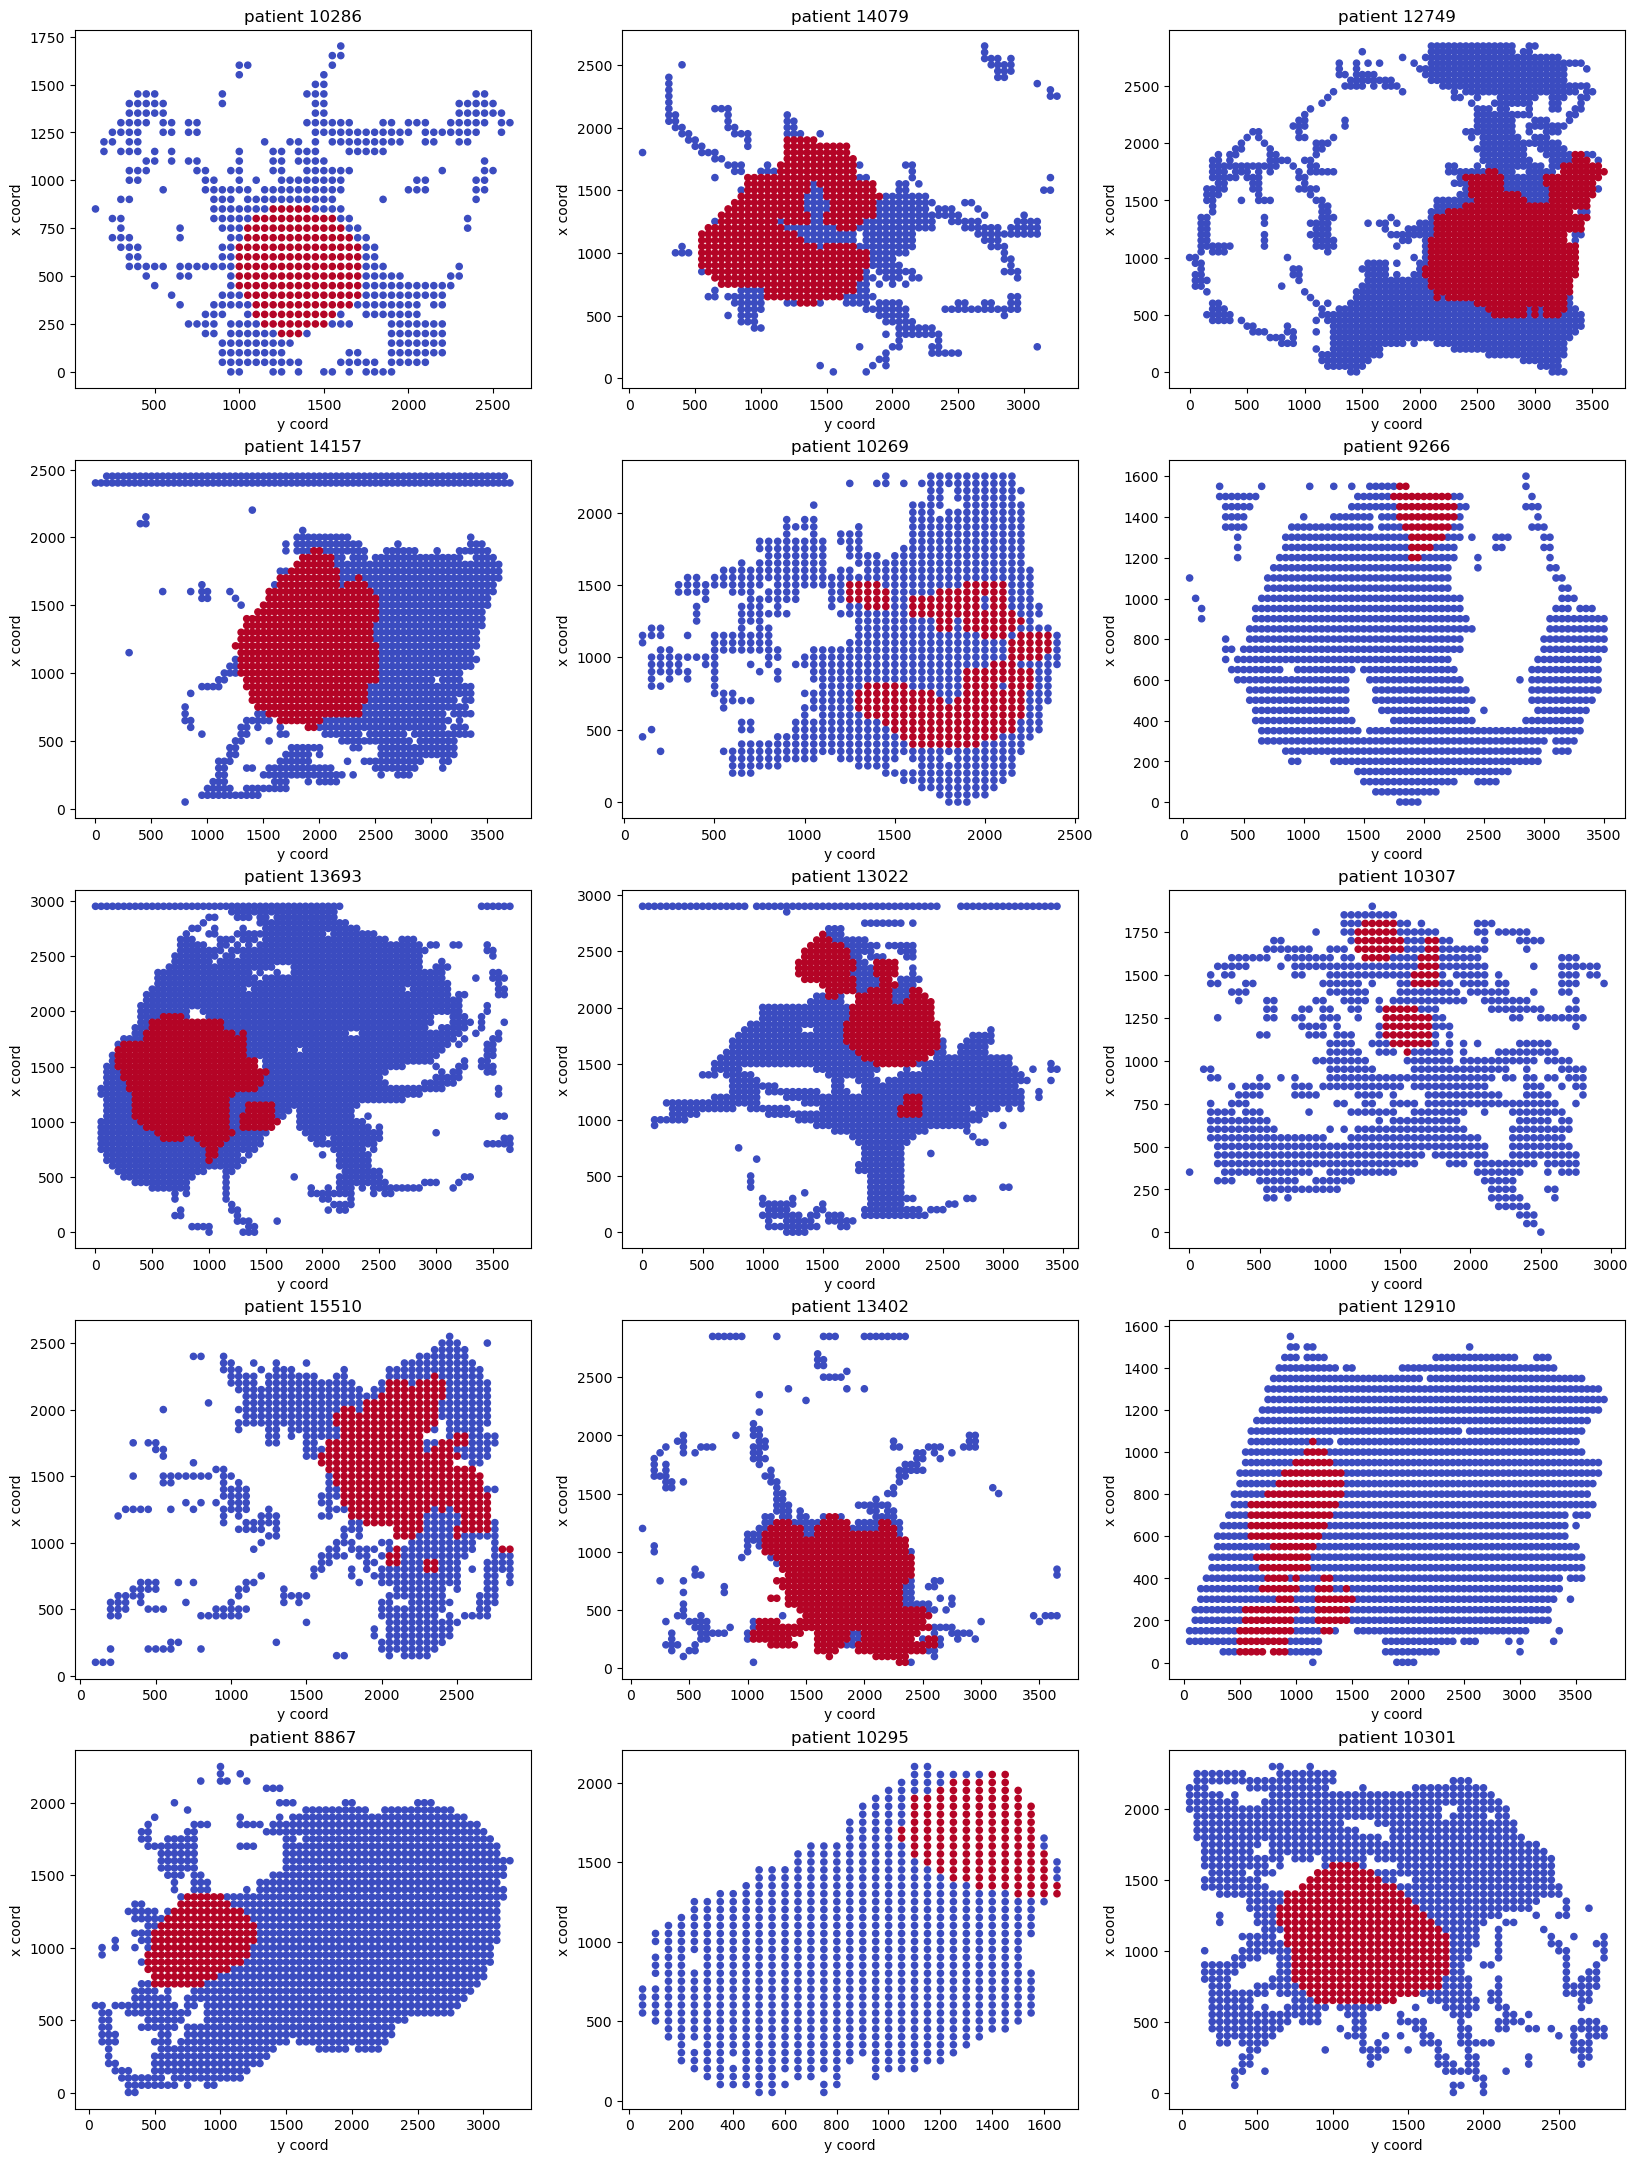

In [18]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

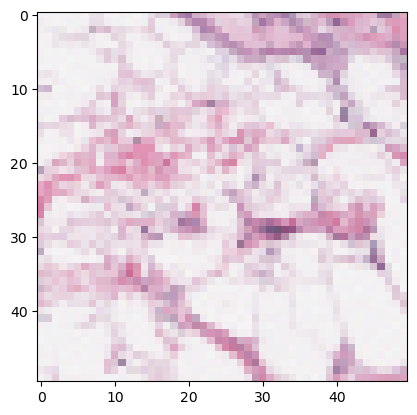

In [19]:
data.target = data.target.astype(np.int64)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

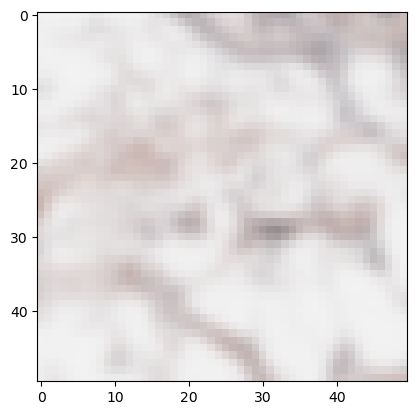

In [20]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

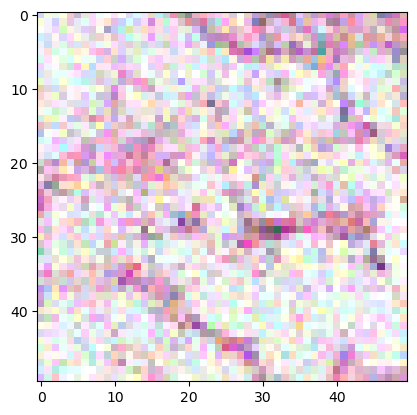

In [21]:
noise_image = random_noise(image)
plt.imshow(noise_image)

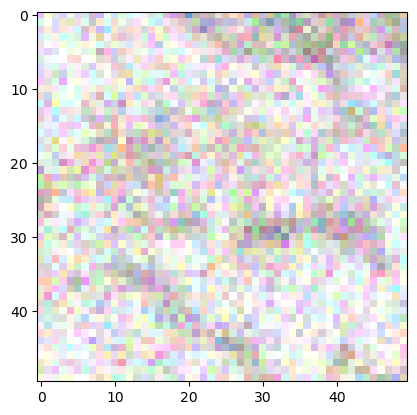

In [22]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

In [23]:
os.makedirs('image_processing', exist_ok=True) 
os.makedirs('image_processing/noise_images', exist_ok=True)

In [24]:
for normal_image in all_rays_dir_lst :
    path        = all_rays_dir+'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)

In [25]:
os.makedirs( 'image_processing/processd_data_train', exist_ok=True)
os.makedirs( 'image_processing/processd_data_test', exist_ok=True)
os.makedirs( 'image_processing/processd_data_train/zeros', exist_ok=True)
os.makedirs( 'image_processing/processd_data_train/ones', exist_ok=True)
os.makedirs( 'image_processing/processd_data_test/zeros', exist_ok=True)
os.makedirs( 'image_processing/processd_data_test/ones', exist_ok=True)

In [26]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0   10286_idx5_x1251_y351_class1.png
1  14079_idx5_x2151_y1401_class0.png
2   12749_idx5_x1451_y701_class0.png
3   14157_idx5_x1651_y301_class0.png
4   10269_idx5_x1351_y651_class1.png

In [27]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0   10286_idx5_x1251_y351_class1.png      1
1  14079_idx5_x2151_y1401_class0.png      0
2   12749_idx5_x1451_y701_class0.png      0
3   14157_idx5_x1651_y301_class0.png      0
4   10269_idx5_x1351_y651_class1.png      1
5    9266_idx5_x1901_y701_class0.png      0
6  13693_idx5_x1901_y2851_class0.png      0
7  13022_idx5_x1501_y1001_class0.png      0
8  10307_idx5_x1351_y1801_class1.png      1
9  15510_idx5_x1801_y1001_class0.png      0

In [28]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [29]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [30]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)

In [31]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [32]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

178864
70907
19874
7879


In [33]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0   10286_idx5_x1251_y351_class1.png      1
1  14079_idx5_x2151_y1401_class0.png      0
2   12749_idx5_x1451_y701_class0.png      0
3   14157_idx5_x1651_y301_class0.png      0
4   10269_idx5_x1351_y651_class1.png      1
5    9266_idx5_x1901_y701_class0.png      0
6  13693_idx5_x1901_y2851_class0.png      0
7  13022_idx5_x1501_y1001_class0.png      0
8  10307_idx5_x1351_y1801_class1.png      1
9  15510_idx5_x1801_y1001_class0.png      0

In [34]:
os.makedirs( 'image_processing/model_tst', exist_ok=True)
os.makedirs( 'image_processing/model_tst/trainig', exist_ok=True)
os.makedirs( 'image_processing/model_tst/testing', exist_ok=True)          
os.makedirs( 'image_processing/model_tst/trainig/zeros', exist_ok=True)
os.makedirs( 'image_processing/model_tst/trainig/ones', exist_ok=True)
os.makedirs( 'image_processing/model_tst/testing/zeros', exist_ok=True)
os.makedirs( 'image_processing/model_tst/testing/ones', exist_ok=True)

In [35]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)

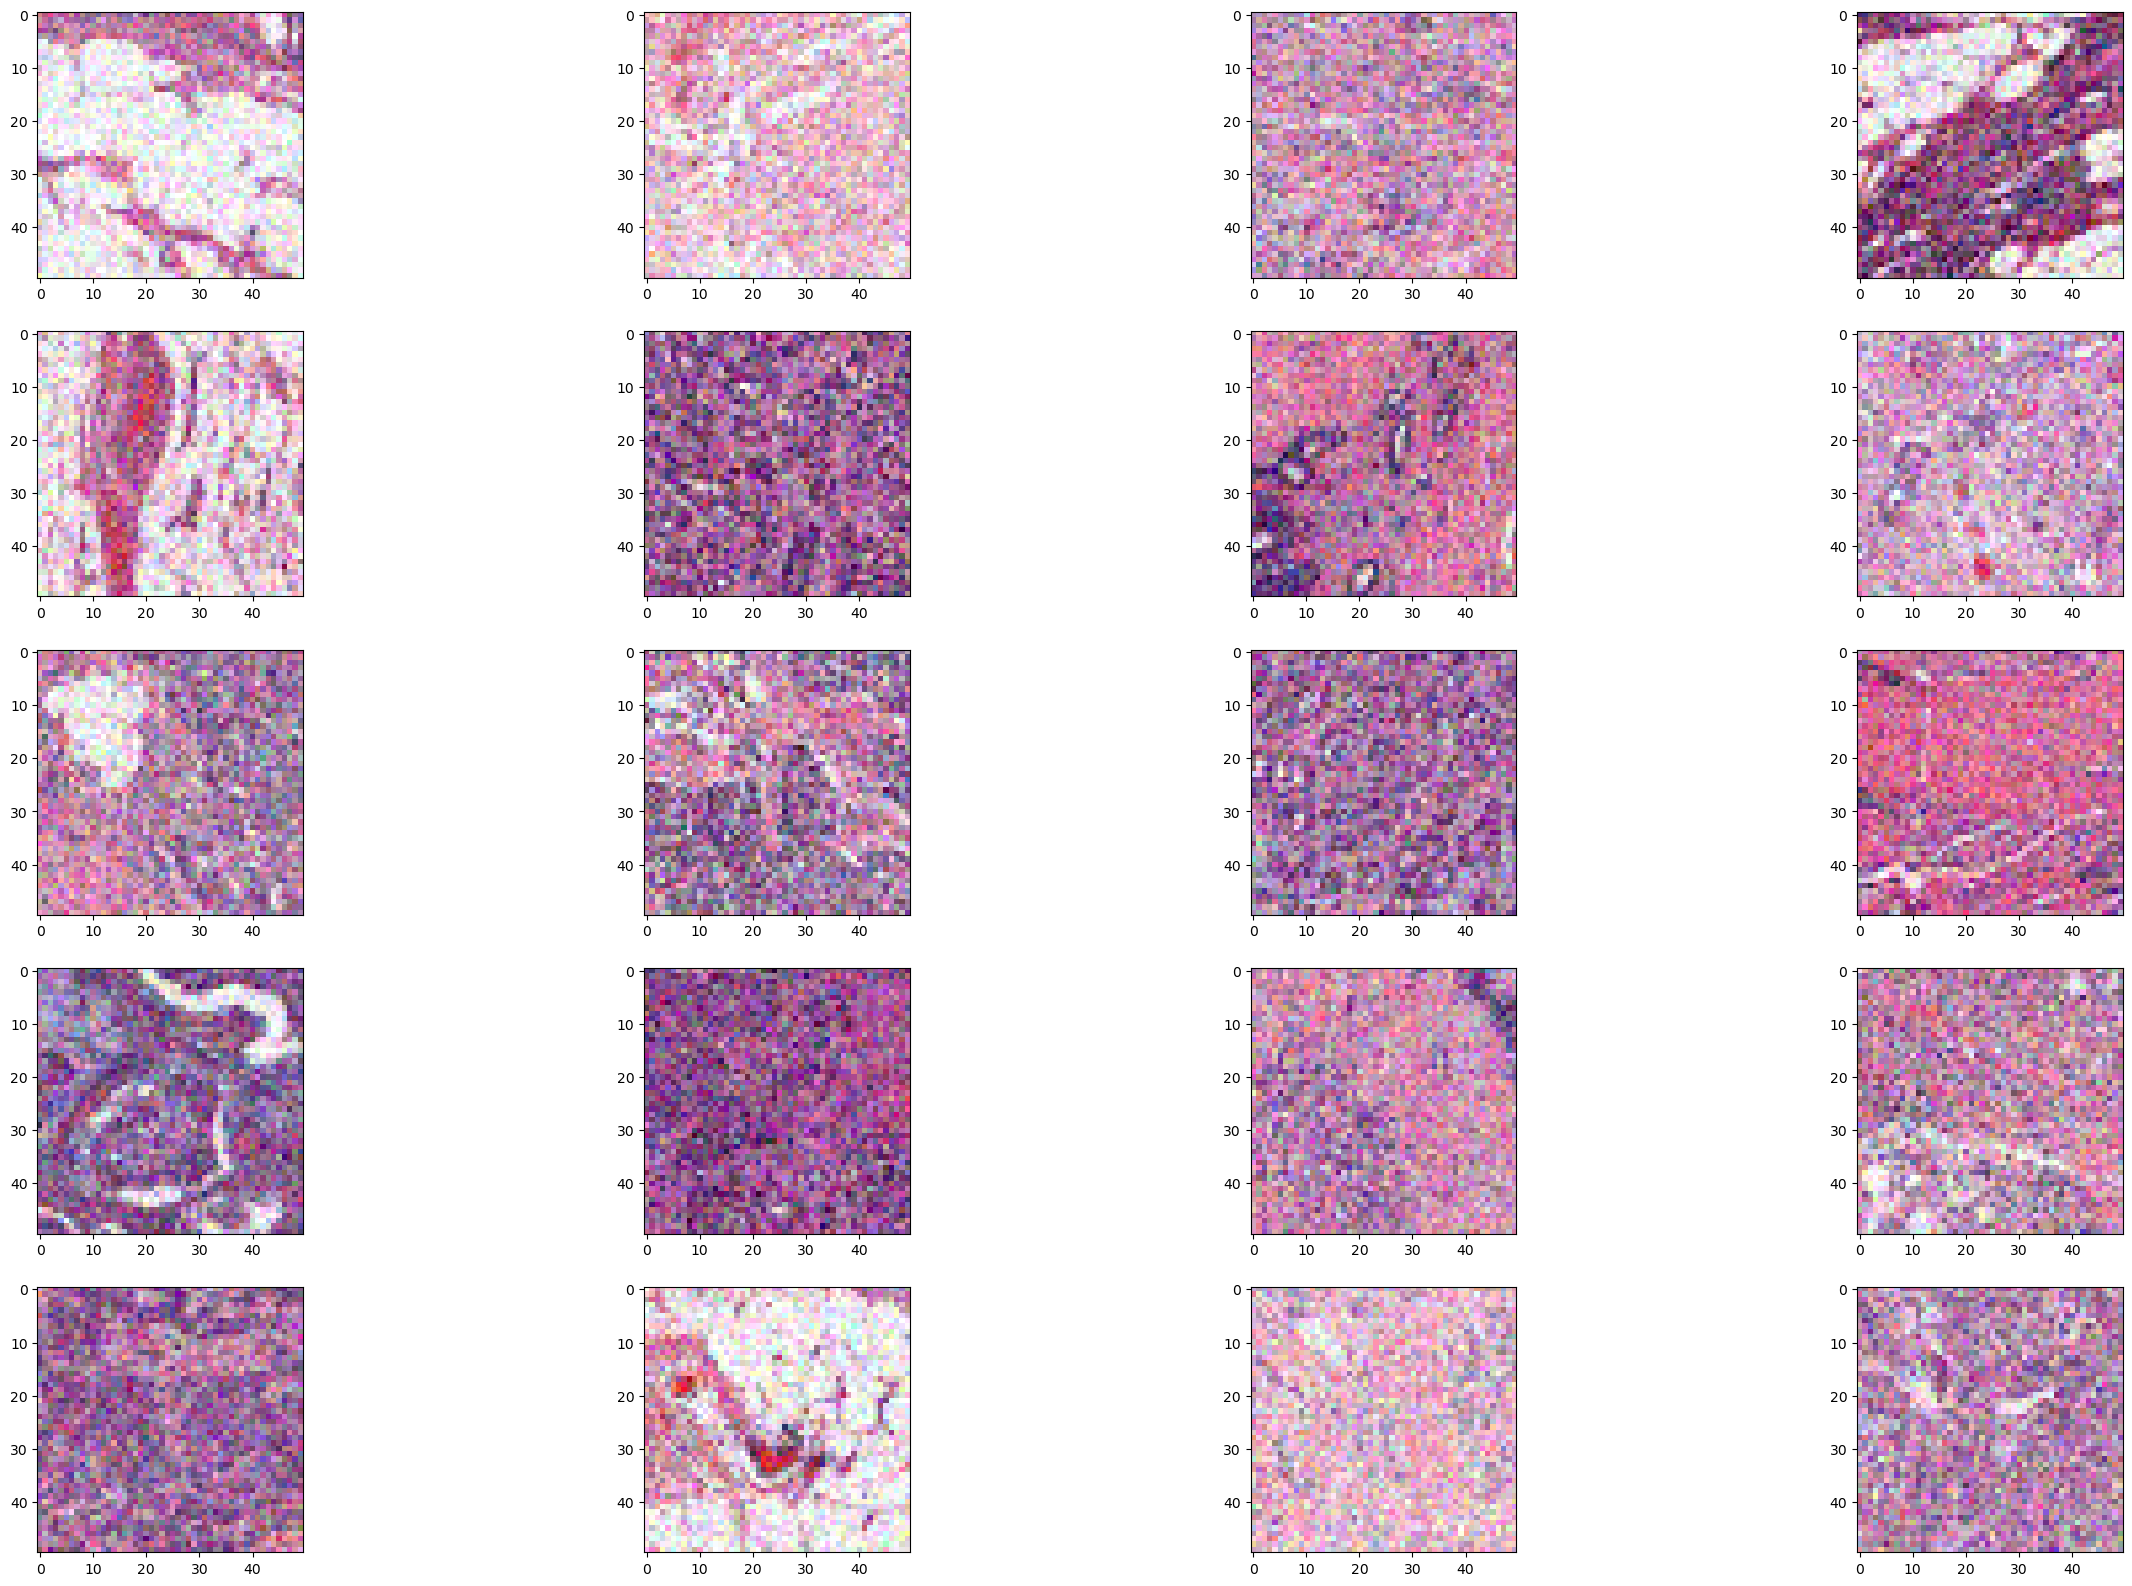

In [36]:
processd_data.target = processd_data.target.astype(np.int64)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

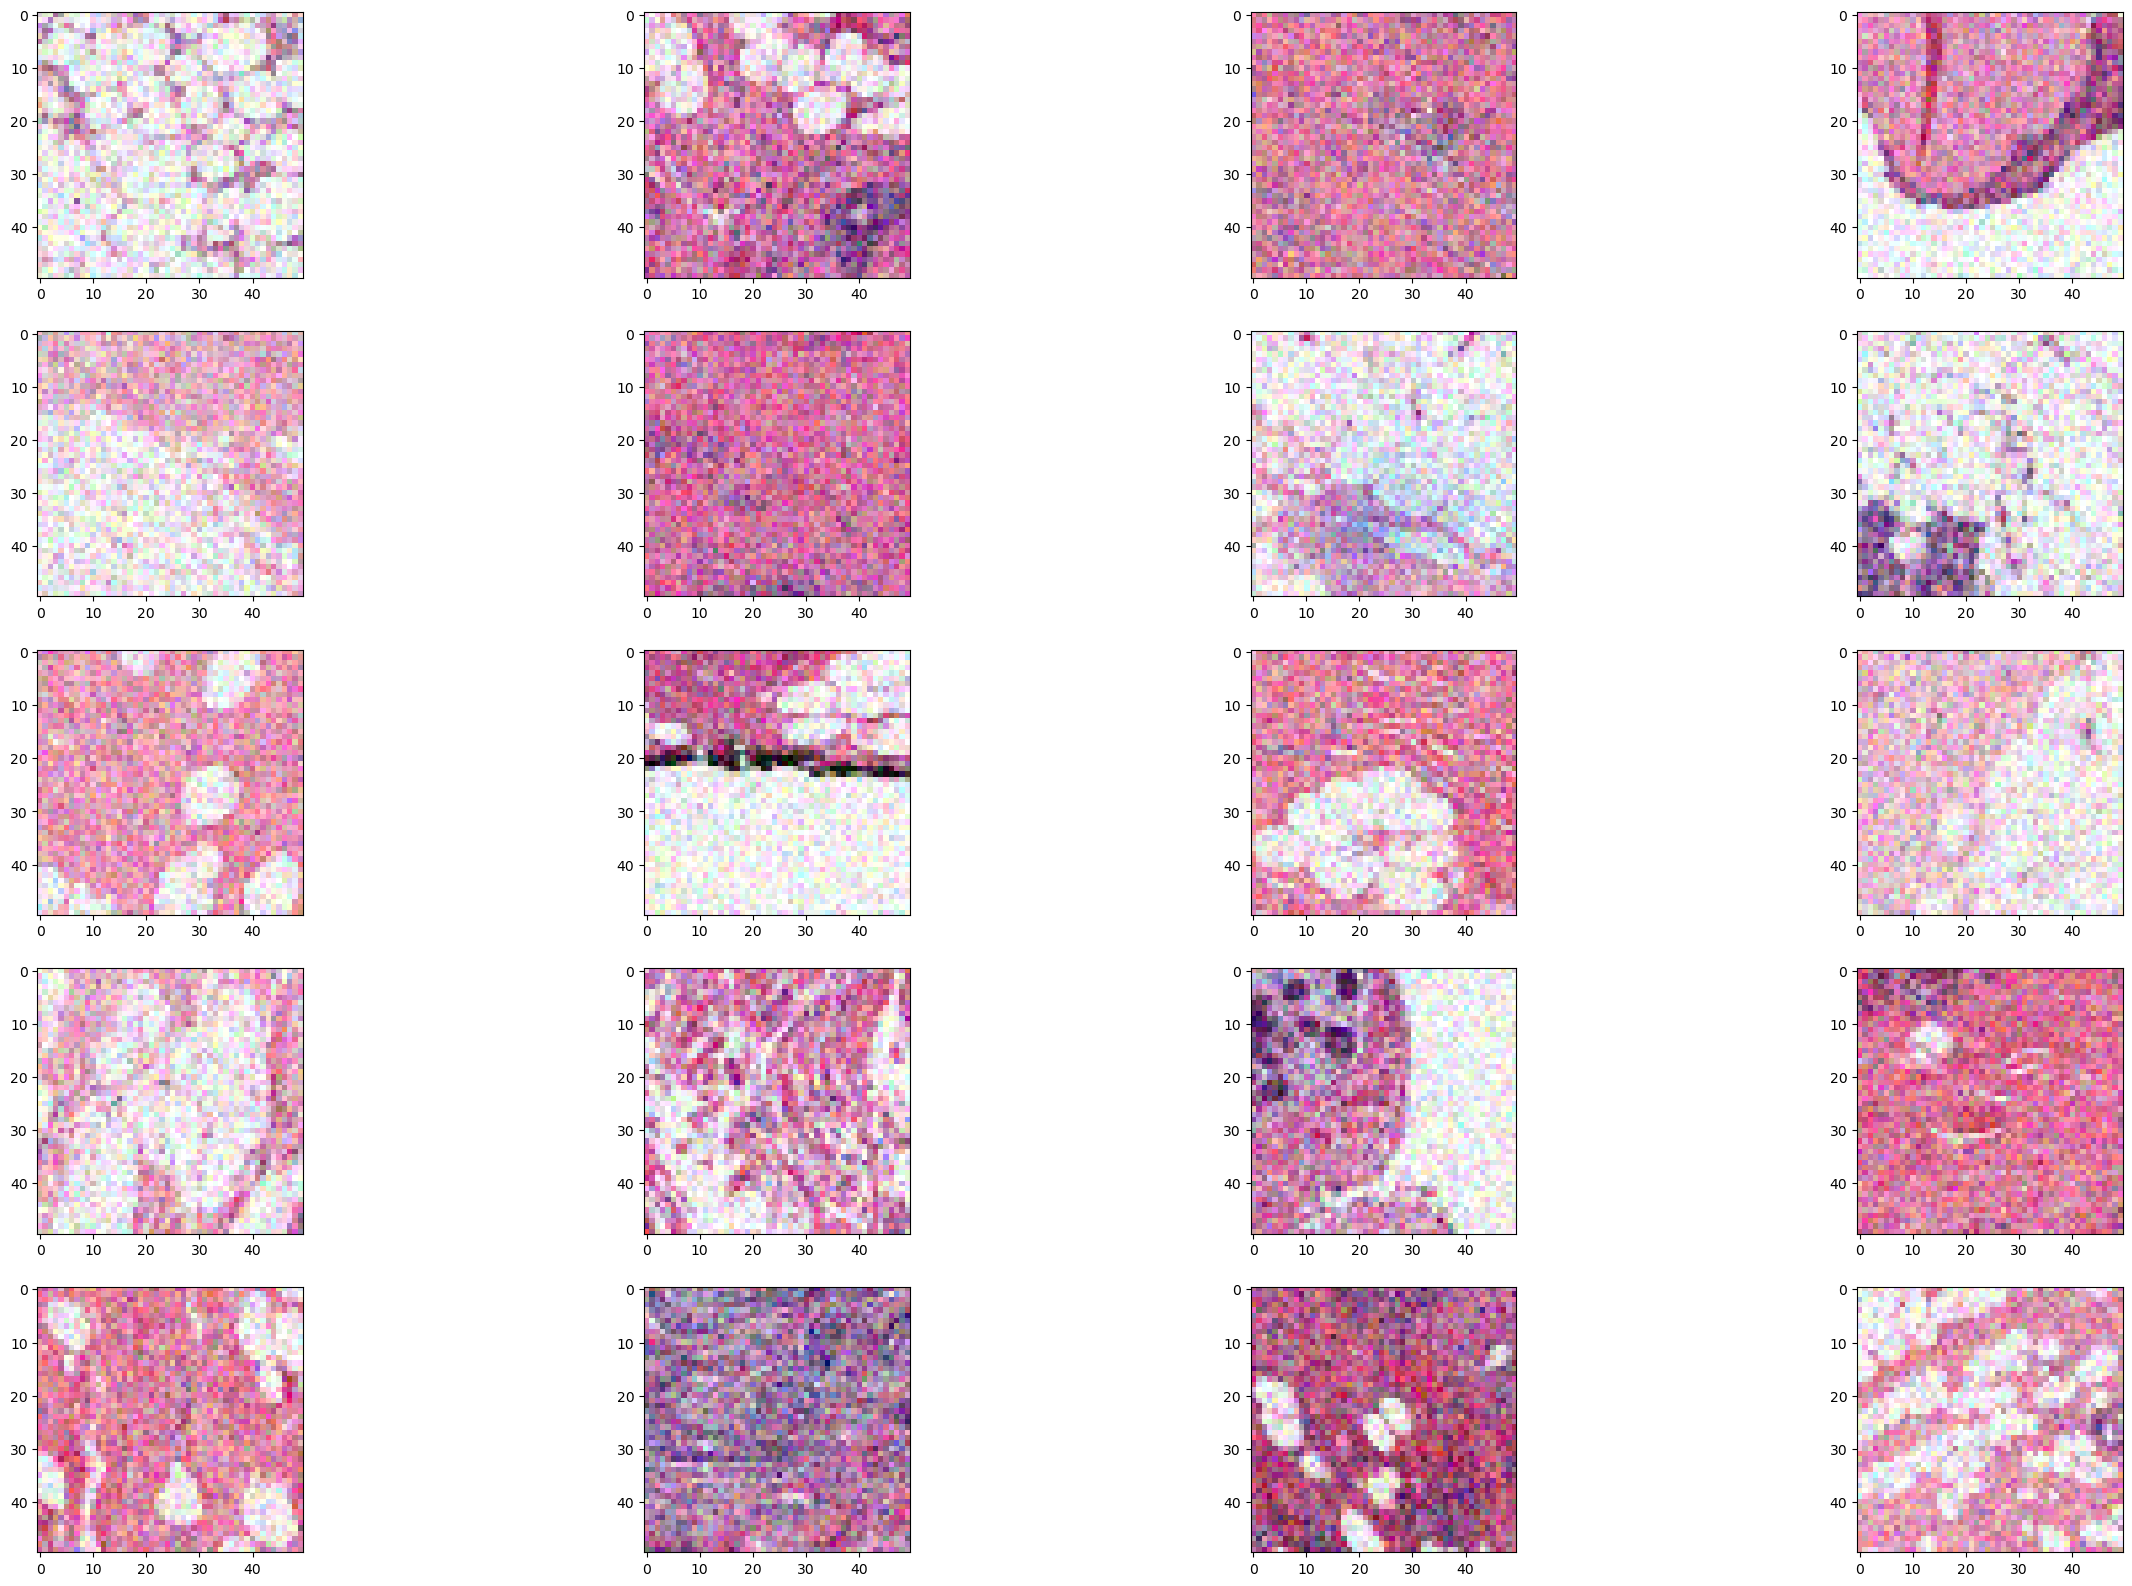

In [37]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [ ]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [39]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())
my_model_im_processd.add(Dense(128,activation='relu'))
my_model_im_processd.add(Dense(2,activation='softmax'))
my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_processd, validation_data=test_generation_processd, epochs=60, verbose=1, callbacks=[early_stop])

Epoch 1/60


/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6957 - loss: 0.6094 - val_accuracy: 0.7770 - val_loss: 0.5054
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7666 - loss: 0.5063 - val_accuracy: 0.7765 - val_loss: 0.4942
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7793 - loss: 0.4876 - val_accuracy: 0.7685 - val_loss: 0.5126
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7879 - loss: 0.4752 - val_accuracy: 0.7940 - val_loss: 0.4703
Epoch 5/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7906 - loss: 0.4659 - val_accuracy: 0.7720 - val_loss: 0.4925
Epoch 6/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8000 - loss: 0.4484 - val_accuracy: 0.7935 - val_loss: 0.4554
Epoch 7/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8118 - loss: 0.4339 - val_accuracy: 0.7070 - val_loss: 0.6260
Epoch 8/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8138 - loss: 0.4315 - val

In [41]:
os.makedirs( 'image_processing/normal', exist_ok=True)
os.makedirs( 'image_processing/normal/model_tst', exist_ok=True) 
os.makedirs( 'image_processing/normal/model_tst/trainig', exist_ok=True)
os.makedirs( 'image_processing/normal/model_tst/testing', exist_ok=True)
os.makedirs( 'image_processing/normal/model_tst/trainig/zeros', exist_ok=True)
os.makedirs( 'image_processing/normal/model_tst/trainig/ones', exist_ok=True)
os.makedirs( 'image_processing/normal/model_tst/testing/zeros', exist_ok=True)
os.makedirs( 'image_processing/normal/model_tst/testing/ones', exist_ok=True)

In [ ]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)

In [43]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [44]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])


/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

my_model_im_processd.fit(
    train_generation_normal,
    validation_data=test_generation_normal,
    epochs=60,
    verbose=1,
    callbacks=[early_stop]  
)

Epoch 1/60
  16/1800 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8701 - loss: 0.3539

/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8227 - loss: 0.4062 - val_accuracy: 0.7930 - val_loss: 0.4872
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8354 - loss: 0.3836 - val_accuracy: 0.7880 - val_loss: 0.5051
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8423 - loss: 0.3623 - val_accuracy: 0.7915 - val_loss: 0.5147


In [46]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0   10286_idx5_x1251_y351_class1.png      1
1  14079_idx5_x2151_y1401_class0.png      0
2   12749_idx5_x1451_y701_class0.png      0
3   14157_idx5_x1651_y301_class0.png      0
4   10269_idx5_x1351_y651_class1.png      1

In [47]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [48]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [49]:
os.makedirs( 'train_dir', exist_ok=True)
os.makedirs('test_dir', exist_ok=True)

In [50]:
os.makedirs( 'train_dir/zeros', exist_ok=True)
os.makedirs( 'train_dir/ones', exist_ok=True)
os.makedirs( 'test_dir/zeros', exist_ok=True)
os.makedirs( 'test_dir/ones', exist_ok=True)

In [51]:
train = data_train.image_id
test  = data_test.image_id

In [52]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [53]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)

In [54]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [55]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [56]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')

Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


In [57]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       663,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
my_model.fit(train_generation, validation_data=test_generation, epochs=60, verbose=1, callbacks=[early_stop])

Epoch 1/60


/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24978/24978 ━━━━━━━━━━━━━━━━━━━━ 148s 6ms/step - accuracy: 0.8043 - loss: 0.4423 - val_accuracy: 0.8397 - val_loss: 0.3722
Epoch 2/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - accuracy: 0.8355 - loss: 0.3874 - val_accuracy: 0.8454 - val_loss: 0.3617
Epoch 3/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 173s 7ms/step - accuracy: 0.8414 - loss: 0.3713 - val_accuracy: 0.8515 - val_loss: 0.3530
Epoch 4/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 169s 7ms/step - accuracy: 0.8445 - loss: 0.3617 - val_accuracy: 0.8524 - val_loss: 0.3446
Epoch 5/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 175s 7ms/step - accuracy: 0.8500 - loss: 0.3520 - val_accuracy: 0.8470 - val_loss: 0.3655
Epoch 6/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 178s 7ms/step - accuracy: 0.8527 - loss: 0.3472 - val_accuracy: 0.8615 - val_loss: 0.3317
Epoch 7/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 193s 8ms/step - accuracy: 0.8544 - loss: 0.3414 - val_accuracy: 0.8588 - val_loss: 0.3314
Epoch 8/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 179s 7ms/step - accuracy: 0.8

In [60]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

accuracy      loss  val_accuracy  val_loss
0  0.818478  0.418762      0.839693  0.372153
1  0.837187  0.383140      0.845422  0.361737
2  0.842624  0.368339      0.851476  0.352998
3  0.846359  0.358482      0.852376  0.344623
4  0.850671  0.351504      0.847008  0.365453

<Axes: >

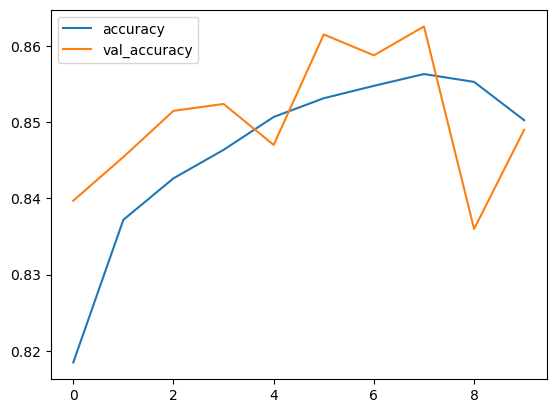

In [61]:
losse[['accuracy','val_accuracy']].plot()

<Axes: >

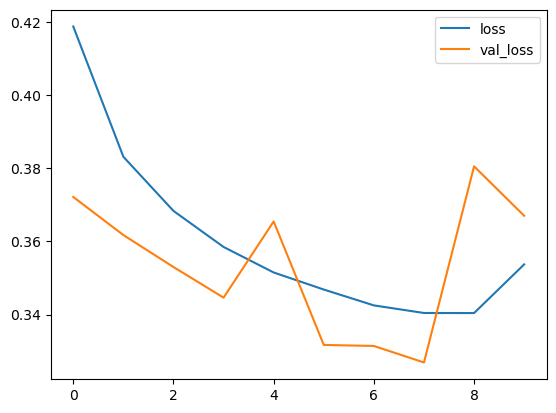

In [62]:
losse[['loss','val_loss']].plot()

In [63]:
val_loss, val_acc = my_model.evaluate(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8493 - loss: 0.3697
val_loss: 0.367008775472641
val_acc: 0.8489893078804016


In [64]:
model_json = my_model.to_json()

In [65]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)

my_model.save_weights("model.weights.h5") 
print("Saved model to disk")


Saved model to disk


In [66]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


In [67]:
class Api_service:
    def __init__(self, img_file_path):
        self.img_file_path = img_file_path

    def prediction_function(self):
        predict_generation = data_generation.flow_from_directory(
            self.img_file_path,
            target_size=(25, 25),
            batch_size=10,
            class_mode='categorical'
        )

        prediction = loaded_model.predict(predict_generation)  
        has_cancer = 'The percentage of cancer: ' + str(round(prediction[0][0] * 100, 2)) + "%"
        has_no_cancer = 'Percentage of no cancer: ' + str(round(prediction[0][1] * 100, 2)) + '%'
        return has_cancer, has_no_cancer

prediction = Api_service("image_processing/normal/model_tst/trainig")
x, y = prediction.prediction_function()
print(x)
print(y)


Found 18000 images belonging to 2 classes.
  26/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step 

/Users/mohammad/miniconda3/envs/main/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
The percentage of cancer: 78.22%
Percentage of no cancer: 21.78%
